<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master/bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\bu}{\boldsymbol{u}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

## Retail Customer Clustering

### Overview
The dataset given is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts.

### Business Goal
We aim to segment the Customers based on RFM so that the company can target its customers efficiently.

The RFM analysis is a marketing technique used to quantitatively rank and group customers based on the recency, frequency and monetary total of their recent transactions to identify the best customers and perform targeted marketing campaigns.

### Data

You are given a dataset: each row represents a transaction (so, if a given customer buys a t-shirt and socks you will have one row for the t-shirt and one row for the socks).

+ InvoiceNo: id of the invoice
+ StockCode: id of the given clothing
+ Description: description of the clothing item
+ Quantity: quantity purchased
+ InvoiceDate: date of the purchase
+ UnitPrice: unit price of the clothing item
+ CustomerID: id of the customer
+ Country: country of the customer


You are asked to **develop a clustering algorithm** to be able to group clients based on their RFM:

+ Recency: days from their last purchase
+ Frecuency: how many times per month/week they buy
+ Monetary: how much is their average ticket

### Business questions

1. **How many groups of customers do we have** 
2. **Which is their profile**


### Steps

You can follow those **steps** :
1. *Explore* and understand the dataset. 
2. Data Cleansing
3. Data preparation (RFM)
4. Assess number of clusters
5. Build clusters
6. Profiling of each cluster: how often they buy, how much, are them a high value group or a low value?

### Data Exploration


In [33]:
import pandas as pd
from datatile.summary.df import DataFrameSummary
pd.set_option('display.max_rows', None)

df = pd.read_csv('retail_data.csv', encoding = 'unicode_escape')
dfs = DataFrameSummary(df)
dfs.summary()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,NaN,NaN,NaN,541909.0,NaN,541909.0,406829.0,NaN
mean,NaN,NaN,NaN,9.55225,NaN,4.611114,15287.69057,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.0,NaN,-11062.06,12346.0,NaN
25%,NaN,NaN,NaN,1.0,NaN,1.25,13953.0,NaN
50%,NaN,NaN,NaN,3.0,NaN,2.08,15152.0,NaN
75%,NaN,NaN,NaN,10.0,NaN,4.13,16791.0,NaN
max,NaN,NaN,NaN,80995.0,NaN,38970.0,18287.0,NaN
counts,541909,541909,540455,541909,541909,541909,406829,541909
uniques,25900,4070,4223,722,23260,1630,4372,38


# Data Cleaning

To Do:
* Identify outliers in quantity, unit price
* Explore missing CustomerID values


## Quantity

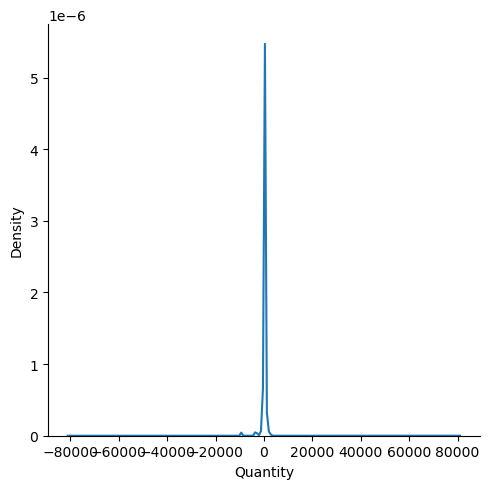

In [34]:
import seaborn as sns
sns.displot(data=df, x="Quantity", kind='kde')

Seems like there's some negative and extreme values skewing the data. Let's check them out. 

In [35]:
quant_neg_big = (df[df['Quantity'] <0])
quant_neg_big.sort_values(by='Quantity').head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,09-12-2011 09:27,2.08,16446.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,18-01-2011 10:17,1.04,12346.0,United Kingdom
225529,556690,23005,printing smudges/thrown away,-9600,14-06-2011 10:37,0.00,NaN,United Kingdom
225530,556691,23005,printing smudges/thrown away,-9600,14-06-2011 10:37,0.00,NaN,United Kingdom
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,02-12-2010 14:23,0.03,15838.0,United Kingdom
225528,556687,23003,Printing smudges/thrown away,-9058,14-06-2011 10:36,0.00,NaN,United Kingdom
115818,546152,72140F,throw away,-5368,09-03-2011 17:25,0.00,NaN,United Kingdom
431381,573596,79323W,"Unsaleable, destroyed.",-4830,31-10-2011 15:17,0.00,NaN,United Kingdom
341601,566768,16045,NaN,-3667,14-09-2011 17:53,0.00,NaN,United Kingdom
323458,565304,16259,NaN,-3167,02-09-2011 12:18,0.00,NaN,United Kingdom


So it looks like a lot of these are discounts and/or damaged stocks, but they're not consistently labeled. SOme are labeled with StockCode D, or the description includes "discount" or "damaged", which would be valid values. Not sure how many of the negative values are errors. 

That said, for clustering a lot of these negative values might not be super useful. We could immediately remove all of them, because there's only like 10k (~2% of the dataset), but if we have data about how many of these customers have gotten a lot of discounts, it could be a decent covariate to use in our regression. 

Let's start identifying discounts

In [36]:
df[df['StockCode'] == 'D']
df['discount'] = (df['StockCode'] == 'D') | (df['Description'].str.contains('iscount'))
df['discount'] = df['discount'].astype(int)

Now let's identify thrown away items

In [37]:
df['thrown_away'] =  (df['Description'].str.contains('amage') | \
                     (df['Description'].str.contains('hrown') | \
                     (df['Description'].str.contains('estroyed') |\
                     (df['Description'].str.contains('unsale') | \
                     df['Description'].str.contains('stock') | \
                     df['StockCode'] == 'M'))))
df['thrown_away'] = df['thrown_away'].astype(int)
df[df['thrown_away'] == 1].count()

InvoiceNo      156
StockCode      156
Description    156
Quantity       156
InvoiceDate    156
UnitPrice      156
CustomerID       0
Country        156
discount       156
thrown_away    156
dtype: int64

Not removing too many values with the obvious cleaning methods. I'm gonna remove all negative values for the time being and focus on the positive outliers.

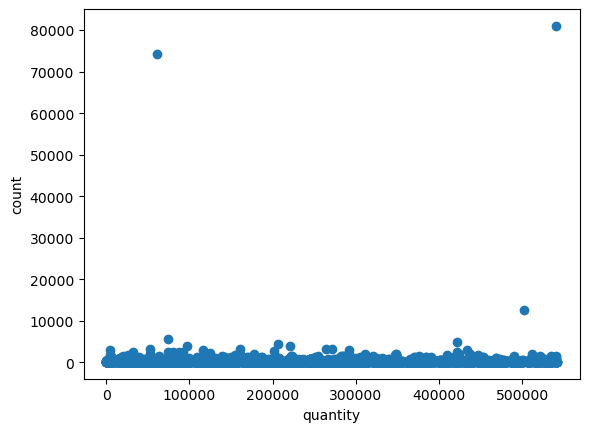

In [38]:
import matplotlib.pyplot as plt
quant_pos_big = df[df['Quantity'] > 100]

plt.scatter(quant_pos_big.index, quant_pos_big['Quantity'])
plt.xlabel("quantity")
plt.ylabel("count")
plt.show()


Looks like 3 values over 10k are skewing the distribution. Let's remove them

In [39]:
quant_pos_big.sort_values(by="Quantity", ascending=False)
quant_pos_big = quant_pos_big.drop(quant_pos_big[quant_pos_big['Quantity'] > 10000].index)


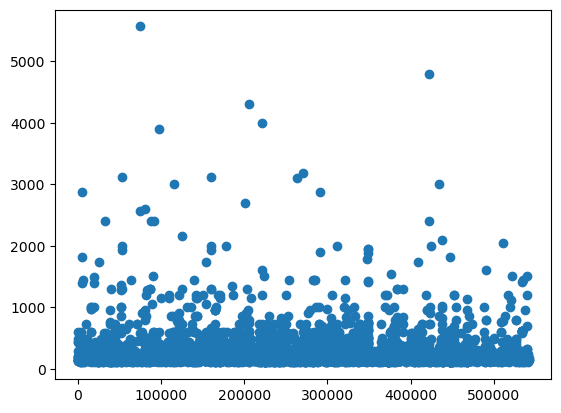

In [40]:
plt.scatter(quant_pos_big.index, quant_pos_big['Quantity'])
plt.show()

OK that looks more normal. Lets drop them from the df, as well as all negative values for the time being. 

In [41]:
df = df.drop(df[df['Quantity'] > 10000].index)
df = df.drop(df[df['Quantity'] < 0].index)

## CustomerID

We have a lot of missing customer ID's. For clustering we don't need to know the individual, so let's drop them for now. 

In [42]:
# df = df.drop(columns='CustomerID')

## UnitPrice

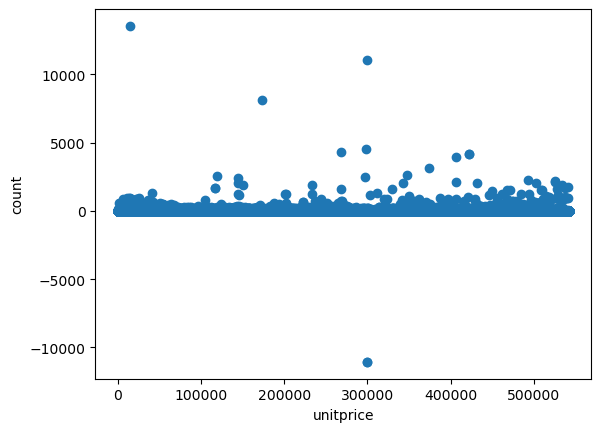

In [43]:
unit_pos_big = df[df['UnitPrice'] >0]

plt.scatter(df['UnitPrice'].index, df['UnitPrice'])
plt.xlabel("unitprice")
plt.ylabel("count")
plt.show()


So it looks like there's one negative value that's screwing everything up. What is it?

In [44]:
df[df['UnitPrice'] <0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,discount,thrown_away
299983,A563186,B,Adjust bad debt,1,12-08-2011 14:51,-11062.06,NaN,United Kingdom,0,0
299984,A563187,B,Adjust bad debt,1,12-08-2011 14:52,-11062.06,NaN,United Kingdom,0,0


So these are bad debt. Since our goal is looking at transactions, let's just drop these two. 

In [45]:
df = df[df['UnitPrice'] >= 0]

Now what about the ones equal to zero? Those aren't purchases, but what are they?

In [46]:
df[df['UnitPrice'] == 0].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,discount,thrown_away
622,536414,22139,NaN,56,01-12-2010 11:52,0.0,NaN,United Kingdom,0,0
1970,536545,21134,NaN,1,01-12-2010 14:32,0.0,NaN,United Kingdom,0,0
1971,536546,22145,NaN,1,01-12-2010 14:33,0.0,NaN,United Kingdom,0,0
1972,536547,37509,NaN,1,01-12-2010 14:33,0.0,NaN,United Kingdom,0,0
1987,536549,85226A,NaN,1,01-12-2010 14:34,0.0,NaN,United Kingdom,0,0
1988,536550,85044,NaN,1,01-12-2010 14:34,0.0,NaN,United Kingdom,0,0
2024,536552,20950,NaN,1,01-12-2010 14:34,0.0,NaN,United Kingdom,0,0
2025,536553,37461,NaN,3,01-12-2010 14:35,0.0,NaN,United Kingdom,0,0
2026,536554,84670,NaN,23,01-12-2010 14:35,0.0,NaN,United Kingdom,0,0
4348,536765,84952C,NaN,19,02-12-2010 14:43,0.0,NaN,United Kingdom,0,0


Lots of different reasons here. But, since our overall goal is to analyze purchases, not refunds, I think we can just remove all of these. 

In [47]:
df = df[df['UnitPrice'] > 0]

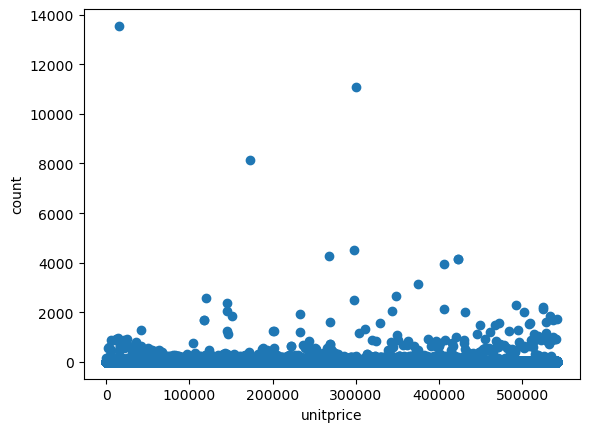

In [48]:
plt.scatter(df['UnitPrice'].index, df['UnitPrice'])
plt.xlabel("unitprice")
plt.ylabel("count")
plt.show()


Let's take a look at the positive outliers. Say, >4k

In [49]:
df.sort_values(by='UnitPrice', ascending=False).head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,discount,thrown_away
15017,537632,AMAZONFEE,AMAZON FEE,1,07-12-2010 15:08,13541.33,NaN,United Kingdom,0,0
299982,A563185,B,Adjust bad debt,1,12-08-2011 14:50,11062.06,NaN,United Kingdom,0,0
173382,551697,POST,POSTAGE,1,03-05-2011 13:46,8142.75,16029.0,United Kingdom,0,0
297723,562955,DOT,DOTCOM POSTAGE,1,11-08-2011 10:14,4505.17,NaN,United Kingdom,0,0
268028,560373,M,Manual,1,18-07-2011 12:30,4287.63,NaN,United Kingdom,0,0
422351,573077,M,Manual,1,27-10-2011 14:13,4161.06,12536.0,France,0,0
422376,573080,M,Manual,1,27-10-2011 14:20,4161.06,12536.0,France,0,0
406406,571751,M,Manual,1,19-10-2011 11:18,3949.32,12744.0,Singapore,0,0
374542,569382,M,Manual,1,03-10-2011 16:44,3155.95,15502.0,United Kingdom,0,0
347948,567353,M,Manual,1,19-09-2011 16:14,2653.95,NaN,Hong Kong,0,0


Looks like these are mostly marked. Let's try removing some of the stock codes. 

In [50]:
df_stockcodes = df.groupby(['StockCode']).count()
df_stockcodes['InvoiceNo'].sort_values(ascending=False).head(10)

StockCode
85123A    2265
85099B    2112
22423     2017
47566     1706
20725     1595
84879     1489
22197     1426
22720     1399
21212     1370
20727     1328
Name: InvoiceNo, dtype: int64

OK so some stock codes have letters. What does that mean? Code below checks only stock codes that contain letters. 

In [52]:
df_letter_stockcodes = df[df['StockCode'].str.contains('(^\D$)', regex=True)]
df_letter_stockcodes

/var/folders/3k/vv4qfkk522sfgpfwfn7vczdh0000gn/T/ipykernel_62316/1893419255.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_letter_stockcodes = df[df['StockCode'].str.contains('(^\D$)', regex=True)]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,discount,thrown_away
2239,536569,M,Manual,1,01-12-2010 15:35,1.25,16274.0,United Kingdom,0,0
2250,536569,M,Manual,1,01-12-2010 15:35,18.95,16274.0,United Kingdom,0,0
5684,536865,M,Manual,1,03-12-2010 11:28,2.55,NaN,United Kingdom,0,0
6798,536981,M,Manual,2,03-12-2010 14:26,0.85,14723.0,United Kingdom,0,0
7976,537077,M,Manual,12,05-12-2010 11:59,0.42,17062.0,United Kingdom,0,0
8530,537137,M,Manual,36,05-12-2010 12:43,0.85,16327.0,United Kingdom,0,0
8587,537140,M,Manual,1,05-12-2010 12:53,0.42,12748.0,United Kingdom,0,0
8588,537140,M,Manual,1,05-12-2010 12:53,0.85,12748.0,United Kingdom,0,0
9326,537199,M,Manual,1,05-12-2010 14:06,0.65,15894.0,United Kingdom,0,0
9575,537208,M,Manual,4,05-12-2010 15:12,0.85,15889.0,United Kingdom,0,0


OK we can drop all of those, since M's are the main ones we wanna get rid of.

In [55]:
df = df[df['StockCode'].str.contains('(^\D$)', regex=True) == False]

/var/folders/3k/vv4qfkk522sfgpfwfn7vczdh0000gn/T/ipykernel_62316/1394381960.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[df['StockCode'].str.contains('(^\D$)', regex=True) == False]


# Prelim analysis

## Purchases by country

Let's figure out which countries we serve the most. Start with a sum of purchases by country

In [23]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'Country', 'discount', 'thrown_away'],
      dtype='object')

In [24]:
df_an = df.copy()

In [25]:
df_an['order_amt'] = df_an['Quantity'] * df_an['UnitPrice']

In [26]:
df_an_ordersbycountry = df_an.groupby(['order_amt', 'Country']).sum()

# Feature Creation

Time difference

In [56]:
import datetime
import time
# today=datetime.datetime(year=2022,month=12,day=1)
# datetime.date.fromtimestamp(time.time())
# datetime.datetime.strptime('01-12-2010 08:26','%d-%m-%Y %H:%M')
df.InvoiceDate=pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')	
# df['recency']=df['InvoiceDate'].apply(lambda x :(today-datetime.datetime.strptime(x.split(' ')[0],'%d-%m-%Y')).days	 )
df['diff']=max(df.InvoiceDate)-df.InvoiceDate

Amount

In [57]:
df['Amount']=df.Quantity*df.UnitPrice

# Model 1

Copied from Tom's model at 12/4 @ 0706

## Preparation

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### RFM tables

In [59]:
monetary=df.groupby('CustomerID')['Amount'].sum()
monetary=monetary.reset_index()
monetary.head(5)

,CustomerID,Amount
0,12347.0,4310.00
1,12348.0,1797.24
2,12349.0,1757.55
3,12350.0,334.40
4,12352.0,1665.74


In [60]:
frequency=df.groupby('CustomerID')['InvoiceNo'].count()
frequency=frequency.reset_index()
frequency.head(5)

,CustomerID,InvoiceNo
0,12347.0,182
1,12348.0,31
2,12349.0,73
3,12350.0,17
4,12352.0,82


In [61]:
recency=df.groupby('CustomerID')['diff'].min()
recency=recency.reset_index()
recency['diff']=recency['diff'].dt.days
recency.head(5)

,CustomerID,diff
0,12347.0,1
1,12348.0,74
2,12349.0,18
3,12350.0,309
4,12352.0,35


Merged

In [67]:
rfm=pd.merge(recency,frequency,on='CustomerID',how='inner')
rfm=pd.merge(rfm,monetary,on='CustomerID',how='inner')
rfm.columns=['CustomerID','Recency','Frequency','Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12347.0,1,182,4310.00
1,12348.0,74,31,1797.24
2,12349.0,18,73,1757.55
3,12350.0,309,17,334.40
4,12352.0,35,82,1665.74


### Scaling

In [69]:
scaler=StandardScaler()
rfm_normalized=rfm[['Recency','Frequency','Monetary']]
scaler.fit(rfm_normalized)
rfm_normalized=pd.DataFrame(scaler.fit_transform(rfm_normalized))
rfm_normalized.columns=['Recency','Frequency','Monetary']
rfm_normalized.head()

,Recency,Frequency,Monetary
0,-0.905397,0.394740,0.272314
1,-0.176463,-0.265633,-0.022254
2,-0.735645,-0.081953,-0.026907
3,2.170103,-0.326859,-0.193741
4,-0.565893,-0.042593,-0.037670


### Elbow Method

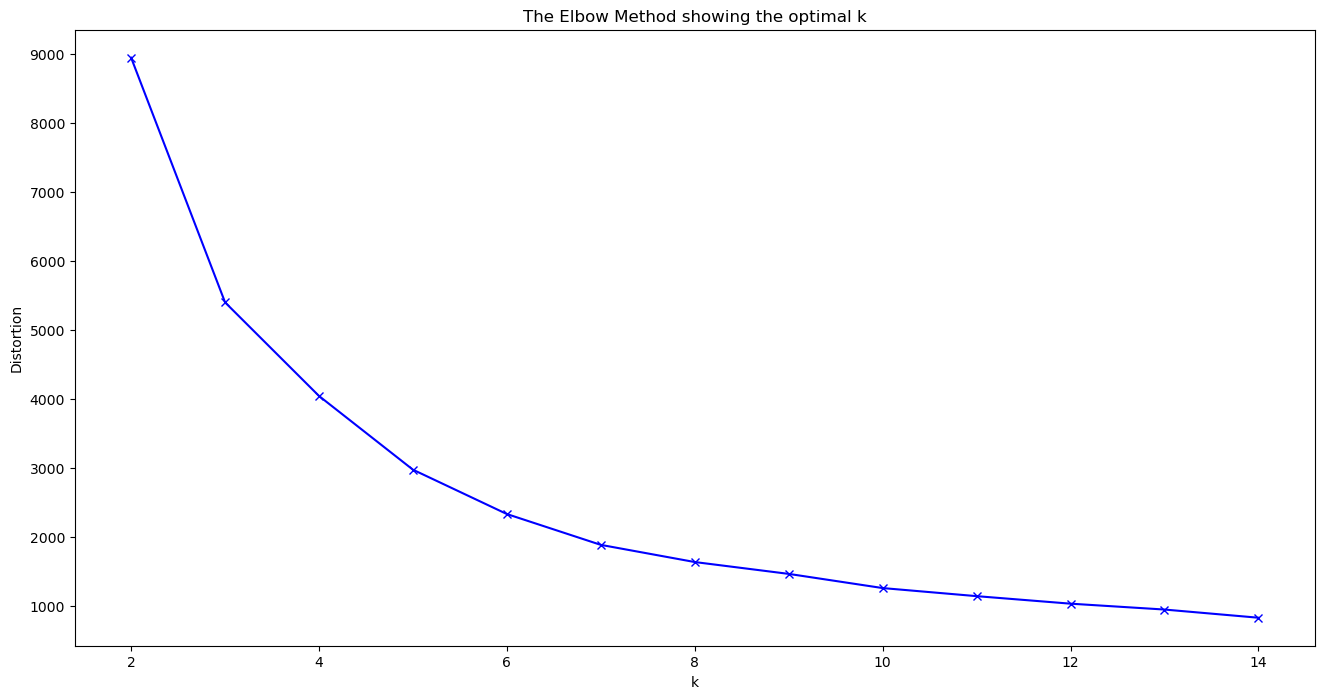

In [70]:
distortions=[]
range_n_clusters=list(range(2,15))
for n in range_n_clusters:
    kmeans=KMeans(n_clusters=n,max_iter=50)
    kmeans.fit(rfm_normalized)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(16,8))
plt.plot(range_n_clusters, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Optimal K is 6? or 7? Going with 6 for now.

## Model creation and visualization

In [71]:
#taking ideal number of clusters as 6
kmeans=KMeans(n_clusters=6,max_iter=50)
kmeans.fit(rfm_normalized)
rfm_normalized['pred_cluster'] = kmeans.predict(rfm_normalized)
rfm_normalized['pred_cluster'].value_counts()

2    2905
0    1059
5     350
4      13
3       4
1       3
Name: pred_cluster, dtype: int64

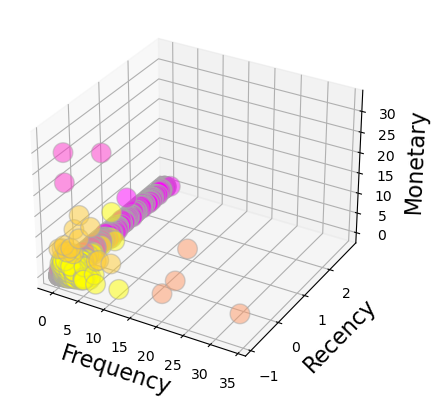

In [72]:
# fig, axes = plt.subplots(1, 2, figsize=(16,8))
# # axes[0].scatter(df_copy['x1'], df_copy['x2'], c=df_copy['true_cluster'])
# axes[1].scatter(df_copy['x1'], df_copy['x2'], c=rfm_normalized['pred_cluster'], cmap=plt.cm.Set1)
# axes[0].set_title('Actual', fontsize=18)
# axes[1].set_title('K_Means', fontsize=18)
from mpl_toolkits.mplot3d import Axes3D
# plt.rcParams['figure.figsize']=(25,25)
fig=plt.figure(1)
# plt.clf()
ax=fig.add_subplot(projection='3d')
# plt.cla()
ax.scatter(rfm_normalized['Frequency'],rfm_normalized['Recency'],rfm_normalized['Monetary'],
c=rfm_normalized['pred_cluster'],s=200,cmap='spring',alpha=0.5,edgecolor='darkgrey')
ax.set_xlabel('Frequency',fontsize=16)
ax.set_ylabel('Recency',fontsize=16)
ax.set_zlabel('Monetary',fontsize=16)
plt.show()

<AxesSubplot:xlabel='pred_cluster', ylabel='Monetary'>

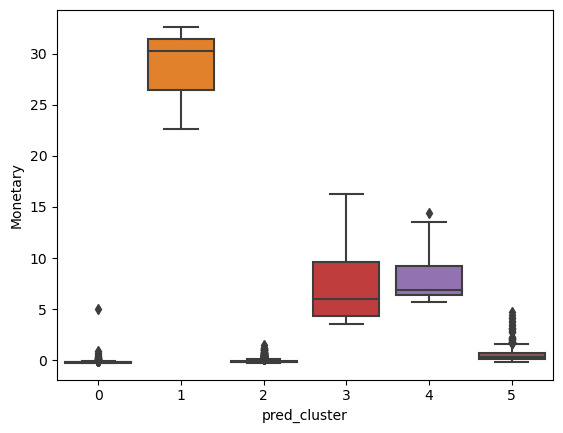

In [73]:
sns.boxplot(x='pred_cluster',y='Monetary',data=rfm_normalized)

<AxesSubplot:xlabel='pred_cluster', ylabel='Recency'>

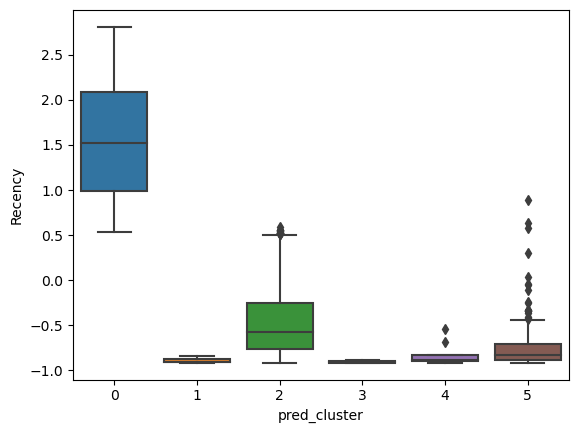

In [74]:
sns.boxplot(x='pred_cluster',y='Recency',data=rfm_normalized)

<AxesSubplot:xlabel='pred_cluster', ylabel='Frequency'>

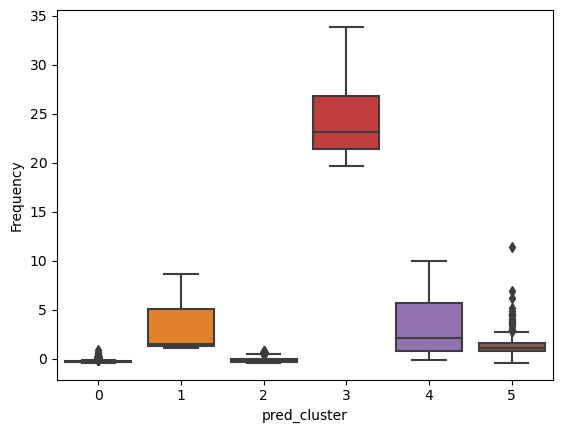

In [75]:
sns.boxplot(x='pred_cluster',y='Frequency',data=rfm_normalized)

<AxesSubplot:xlabel='Frequency', ylabel='Monetary'>

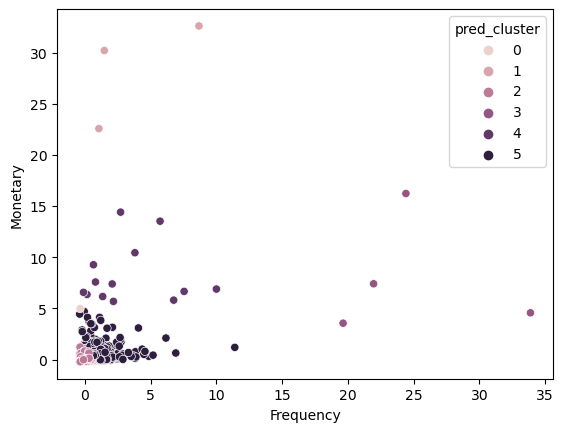

In [76]:
sns.scatterplot(y='Monetary',x='Frequency',data=rfm_normalized, hue='pred_cluster')

<AxesSubplot:xlabel='Recency', ylabel='Monetary'>

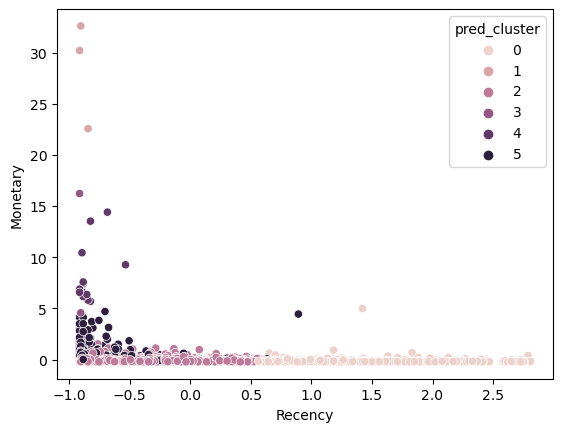

In [77]:
sns.scatterplot(y='Monetary',x='Recency',data=rfm_normalized, hue='pred_cluster')

<AxesSubplot:xlabel='Frequency', ylabel='Monetary'>

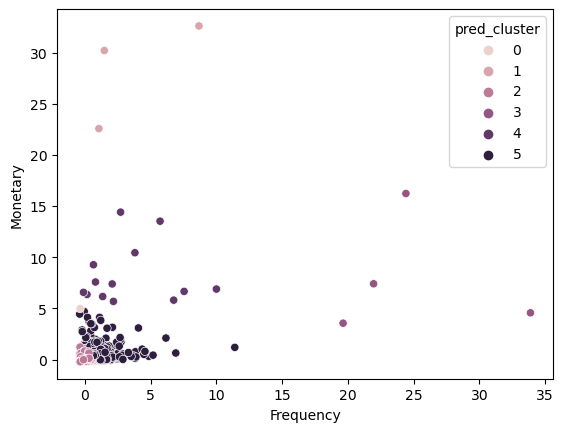

In [78]:
sns.scatterplot(y='Monetary',x='Frequency',data=rfm_normalized, hue='pred_cluster')

<AxesSubplot:xlabel='Recency', ylabel='Frequency'>

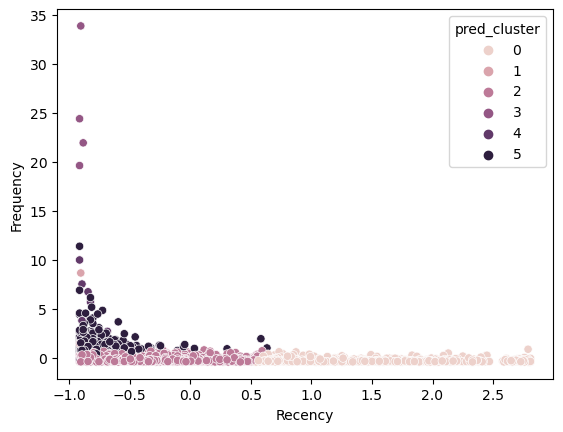

In [79]:
sns.scatterplot(x='Recency',y='Frequency',data=rfm_normalized, hue='pred_cluster')

# Model 2

## Silhouette score

Using Silhouette score analysis

In [80]:
for n in range_n_clusters:
    kmeans=KMeans(n_clusters=n,max_iter=50)
    kmeans.fit(rfm_normalized)
    cluster_labels=kmeans.labels_
    #score
    silhouette_avg=silhouette_score(rfm_normalized,cluster_labels)
    print(f"For n_clusters={n},the silhouette score is {silhouette_avg}")

For n_clusters=2,the silhouette score is 0.6585087105574753
For n_clusters=3,the silhouette score is 0.7462787492228948
For n_clusters=4,the silhouette score is 0.7594167112105985
For n_clusters=5,the silhouette score is 0.7596047795351358
For n_clusters=6,the silhouette score is 0.7646020760355298
For n_clusters=7,the silhouette score is 0.7076470965863711
For n_clusters=8,the silhouette score is 0.4754557185171035
For n_clusters=9,the silhouette score is 0.4773837813485209
For n_clusters=10,the silhouette score is 0.4748899347177547
For n_clusters=11,the silhouette score is 0.47362757110020615
For n_clusters=12,the silhouette score is 0.4606556854248794
For n_clusters=13,the silhouette score is 0.46053235307716966
For n_clusters=14,the silhouette score is 0.4609801731640083


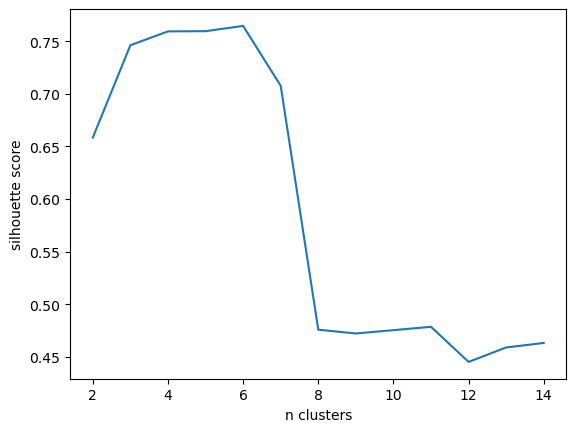

In [94]:
sil_score =  {"n":[],"score":[]}

for n in range_n_clusters:
    kmeans=KMeans(n_clusters=n,max_iter=50)
    kmeans.fit(rfm_normalized)
    cluster_labels=kmeans.labels_
    #score
    silhouette_avg=silhouette_score(rfm_normalized,cluster_labels)
    sil_score['n'].append(n)
    sil_score['score'].append(silhouette_avg)

plt.plot(sil_score['n'], sil_score['score'])
plt.xlabel("n clusters")
plt.ylabel("silhouette score")
plt.show()

Best number of clusters is equal to 6

## RFM tables

In [96]:
kmeans=KMeans(n_clusters=6,max_iter=50)
kmeans.fit(rfm_normalized)
rfm_normalized.loc[:,'CustomerID']=rfm['CustomerID']
rfm_normalized.head()

,Recency,Frequency,Monetary,pred_cluster,CustomerID
0,-0.905397,0.394740,0.272314,2,12347.0
1,-0.176463,-0.265633,-0.022254,2,12348.0
2,-0.735645,-0.081953,-0.026907,2,12349.0
3,2.170103,-0.326859,-0.193741,0,12350.0
4,-0.565893,-0.042593,-0.037670,2,12352.0


## Visualization

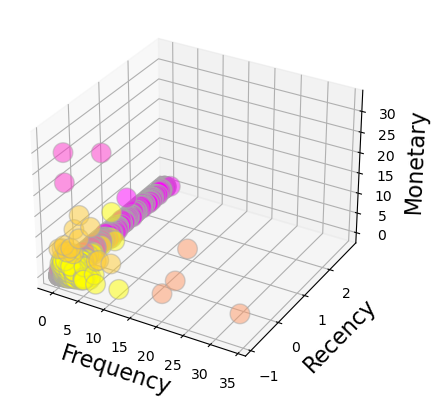

In [97]:
fig=plt.figure(1)
# plt.clf()
ax=fig.add_subplot(projection='3d')
# plt.cla()
ax.scatter(rfm_normalized['Frequency'],rfm_normalized['Recency'],rfm_normalized['Monetary'],
c=rfm_normalized['pred_cluster'],s=200,cmap='spring',alpha=0.5,edgecolor='darkgrey')
ax.set_xlabel('Frequency',fontsize=16)
ax.set_ylabel('Recency',fontsize=16)
ax.set_zlabel('Monetary',fontsize=16)
plt.show()